In [1]:
import keras.callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dropout
%matplotlib inline
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers, models

In [2]:
def prepareData():
    allData = pd.read_csv("data/songs_with_genre.csv", index_col=0,
                          header=[0, 1, 2])
    generes = allData["genre_id"]
    genres_index = pd.read_csv("data/genres_index.csv", index_col=0)
    allData.drop(columns=["genre_id"], inplace=True)
    data_x = allData
    data_x.columns = range(data_x.shape[1])
    #normalizing
    mu = np.mean(data_x, axis=0)
    sigma = (np.std(data_x, axis=0))
    data_x = (data_x - mu) / sigma
    #Creating the right lables
    generes.columns = range(generes.shape[1])
    targets = OneHotEncoder().fit_transform(genres_index).toarray()
    generes[0] = generes[0] - 1
    data_y = [targets[i - 1] for i in generes[0]]
    generes[0] = data_y

    test = generes.copy()
    test.rename(columns={0: "oneHotVector"}, inplace=True)
    test.shape
    split = pd.DataFrame(test["oneHotVector"].to_list(), columns=range(161))
    split.index = generes.index
    generes = split
    return data_x, generes

In [3]:
data_x, labels = prepareData()
x_train, x_rest, y_train, y_rest = train_test_split(data_x, labels, train_size=0.8)
x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)
print(x_train.shape), print(len(y_train))
print(x_valid.shape), print(len(y_valid))
print(x_test.shape), print(len(y_test))

(39678, 518)
39678
(4960, 518)
4960
(4960, 518)
4960


(None, None)

In [4]:
n_features, n_outputs = x_train.shape[1], y_train.shape[1]
CNN = models.Sequential()
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu',
                      input_shape=(n_features, 1), padding='same'))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN.add(layers.Dropout(0.6))  #0.6
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(n_outputs, activation='softmax'))
CNN.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [5]:
# n_features, n_outputs = x_train.shape[1], y_train.shape[1]
# CNN = models.Sequential()
# CNN.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu',
#                       input_shape=(n_features, 1), padding='same'))
# CNN.add(layers.MaxPooling1D(pool_size=4))
# CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
# CNN.add(layers.MaxPooling1D(pool_size=4))
# CNN.add(layers.Dropout(0.6))
# CNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
# CNN.add(layers.MaxPooling1D(pool_size=4))
# CNN.add(layers.Dropout(0.3))
# CNN.add(layers.Flatten())
# CNN.add(layers.Dense(64, activation='relu'))
# CNN.add(layers.Dense(n_outputs, activation='softmax'))
# CNN.save('saved_model/my_model')

In [6]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 518, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 259, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 257, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 128, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 126, 128)          24704     
                                                                 
 dropout (Dropout)           (None, 126, 128)          0

In [7]:
CNN.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [8]:
callback = [keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=15)]
training = CNN.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=389, callbacks=callback)

Epoch 1/30
102/102 [==============================] - 55s 524ms/step - loss: 1.5994 - accuracy: 0.5142 - val_loss: 1.2961 - val_accuracy: 0.6105

<AxesSubplot: >

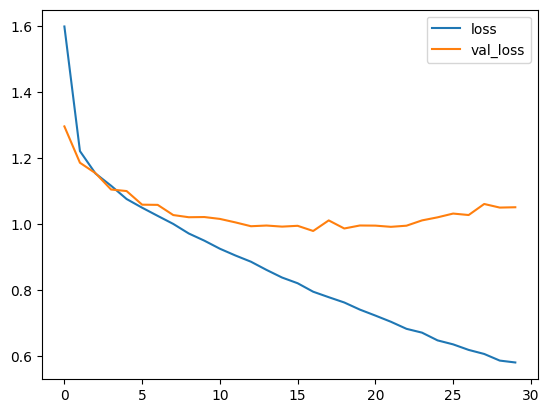

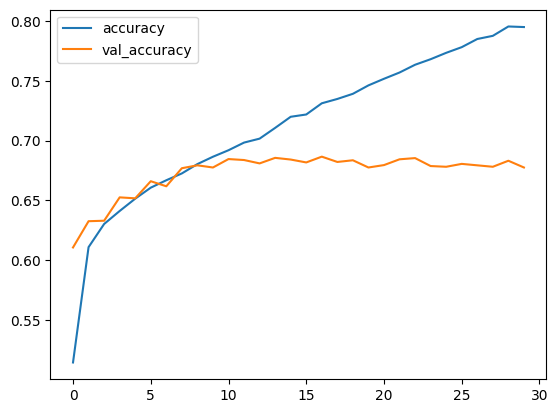

In [9]:
# _, accuracy = CNN.evaluate(x_valid, y_valid, verbose=0)
# print(accuracy)
metrics_df = pd.DataFrame(training.history)
metrics_df[["loss","val_loss"]].plot()
metrics_df[["accuracy", "val_accuracy"]].plot()

In [10]:
_, accuracy_test = CNN.evaluate(x_test, y_test, verbose=0)
print(accuracy_test)

0.6786290407180786


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

ypred = CNN.predict(x_test)
y_pred = (ypred > 0.5)
y = y_test.values
y = (y > 0.5)
# print(y)
# print(y_pred)

155/155 [==============================] - 3s 14ms/step

In [12]:
print('Accuracy score : ', accuracy_score(y, y_pred))
print('Precision score : ', precision_score(y, y_pred, average='weighted'))
print('Recall score : ', recall_score(y, y_pred, average='weighted'))
print('F1 score : ', f1_score(y, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

Accuracy score :  0.6100806451612903
Precision score :  0.733105647930141
Recall score :  0.6100806451612903
F1 score :  0.6526391973800836
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        20
           1       0.53      0.30      0.39        53
           2       0.82      0.78      0.80       122
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.95      0.97        56
           6       0.89      0.36      0.52        22
           7       0.52      0.11      0.18       242
           8       0.00      0.00      0.00         0
           9       0.82      0.80      0.81      1454
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        16
          12       0.69      0.63      0.66       882
          13       0.00      0.00      0.00         0
          14       0.69      0.54      0.60      